# Insper: Profa Maria Kelly Venezuela

# Ciência dos dados: Engenharias

# Projeto 3: PNADC - Uso dos microdados de 2023

# Grupo: Danilo Ramos, Leonardo Veras e Thomas Ganut
___


In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from funcao import regress, pega_variaveis

import pandas as pd # data processing
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization

from sklearn.model_selection import train_test_split # data split

from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm

from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn import svm
from sklearn.svm import SVC

from statsmodels.stats.outliers_influence import variance_inflation_factor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


sb.set_style('whitegrid') # plot style

___
## A. Introdução

### Objetivo escolhido:

O **tema** escolhido pelo grupo é como a classe social e a área de atuação podem determinar o salário de um indíviduo.
<br><br>

O ***df*** escolhido pelo grupo é "Qual era o rendimento bruto/retirada mensal que ... recebia/fazia normalmente nesse trabalho? (valor em dinheiro)" (variável V403312 - quantitativa).

O grupo dividiu as ***features*** escolhidas para o projeto em três temas, sendo estes "Classe social", "Área de atuação" e "Classificações gerais".

#### Classe social
- Cor ou raça (V2010)
- ... sabe ler e escrever? (V3001)
- A escola que ... frequenta é de (V3002A)
- Nível de instrução mais elevado alcançado (pessoas de 5 anos ou mais de idade) padronizado para o Ensino fundamental -  SISTEMA DE 9 ANOS (VD3004)

#### Área de atuação
- Nesse trabalho, ... tinha carteira de trabalho assinada? (V4029)

#### Classificações gerais
- Unidade da Federação (UF)
- Tipo de área (V1023)
- Idade do morador na data de referência (V2009)

___
# Leitura da base de dados - PNADC 2023:

In [288]:
df = pd.read_csv('output.csv')

df = df.dropna(subset=['Salario', 'Carteira', 'LocalTrabalho']).reset_index(drop=True)

Outliers removidos: 8405


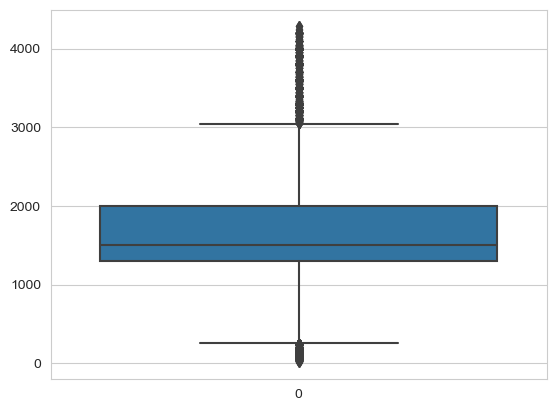

In [289]:
# Limpar os outliers

# Calcular os quartis e o IQR
Q1 = df['Salario'].quantile(0.25)
Q3 = df['Salario'].quantile(0.75)
IQR = Q3 - Q1

# Definir limites inferior e superior para os outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar os dados, removendo os outliers
df_sem_outliers = df[(df['Salario'] >= limite_inferior) & (df['Salario'] <= limite_superior)].reset_index(drop=True)

# Verificar a quantidade de outliers removidos
print(f"Outliers removidos: {len(df) - len(df_sem_outliers)}")

sns.boxplot(df_sem_outliers['Salario'])
df = df_sem_outliers


In [290]:
# Mudando o tipo para 'category'
colunas = ['Estado', 'AreaRes', 'CorRaca', 'Analfabeto', 'Carteira', 'Instrucao', 'TipoTrabalho', 'LocalTrabalho']
for coluna in colunas:
    df[coluna] = df[coluna].astype('category')

# Renomeando as categorias
df['Estado'] = df['Estado'].cat.rename_categories({
    11: 'Rondônia', 12: 'Acre', 13: 'Amazonas', 14: 'Roraima', 15: 'Pará', 16: 'Amapá', 17: 'Tocantins', 
    21: 'Maranhão', 22: 'Piauí', 23: 'Ceará', 24: 'Rio Grande do Norte', 25: 'Paraíba', 26: 'Pernambuco', 27: 'Alagoas', 28: 'Sergipe', 29: 'Bahia', 
    31: 'Minas Gerais', 32: 'Espírito Santo', 33: 'Rio de Janeiro', 35: 'São Paulo', 
    41: 'Paraná', 42: 'Santa Catarina', 43: 'Rio Grande do Sul', 
    50: 'Mato Grosso do Sul', 51: 'Mato Grosso', 52: 'Goiás', 53: 'Distrito Federal'
})

df['AreaRes'] = df['AreaRes'].cat.rename_categories({
    1: 'Capital', 2: "Resto da RM", 3: 'Resto da RIDE', 4: 'Resto da UF' # RIDE = Região Integrada de Desenvolvimento Econômico
})

df['CorRaca'] = df['CorRaca'].cat.rename_categories({
    1: 'Branca', 2: 'Preta', 3: 'Amarela', 4: 'Parda', 5: 'Indigena', 9: 'Ignorado' 
})

df['Analfabeto'] = df['Analfabeto'].cat.rename_categories({
    1: 'Nao', 2: 'Sim'
})

df['Carteira'] = df['Carteira'].cat.rename_categories({
    1: 'Sim', 2: 'Nao'
})

df['Instrucao'] = df['Instrucao'].cat.rename_categories({
    1: '<1 ano', 2: 'Fund. incompleto', 3: 'Fund. completo', 4: 'EM incompleto', 5: 'EM completo', 6: 'Sup. incompleto', 7: 'Sup. completo', 
})

df['TipoTrabalho'] = df['TipoTrabalho'].cat.rename_categories({
    1: 'Trabalhador doméstico',
    2: 'Militar',
    3: 'Setor privado',
    4: 'Setor público',
    5: 'Empregador',
    6: 'Conta própria',
    7: 'Familiar não remunerado'
})

df['LocalTrabalho'] = df['LocalTrabalho'].cat.rename_categories({
    1: 'Cidade', 2: 'Fazenda', 3: 'Nao tinha estabelecimento'
})

df

,Estado,AreaRes,Idade,CorRaca,Analfabeto,TipoTrabalho,LocalTrabalho,Carteira,Salario,Instrucao
0,Rondônia,Capital,32,Parda,Nao,Setor privado,Cidade,Sim,2500.0,EM completo
1,Rondônia,Capital,30,Branca,Nao,Setor privado,Cidade,Sim,3000.0,Sup. completo
2,Rondônia,Capital,43,Branca,Nao,Setor privado,Cidade,Sim,2000.0,Sup. completo
3,Rondônia,Capital,37,Parda,Nao,Setor privado,Cidade,Nao,1300.0,Fund. incompleto
4,Rondônia,Capital,60,Parda,Nao,Setor público,Cidade,Sim,2200.0,Fund. incompleto
...,...,...,...,...,...,...,...,...,...,...
91979,Distrito Federal,Capital,53,Parda,Nao,Setor privado,Cidade,Sim,3200.0,EM completo
91980,Distrito Federal,Capital,23,Preta,Nao,Setor privado,Cidade,Nao,1400.0,Sup. completo
91981,Distrito Federal,Capital,22,Preta,Nao,Setor privado,Cidade,Nao,3000.0,Sup. incompleto
91982,Distrito Federal,Capital,54,Parda,Nao,Setor privado,Cidade,Sim,1500.0,EM incompleto


In [291]:
# Limpando o DF

# Limita a idade entre 18 e 62 anos (maior de idade e não aposentado)
# df = df.loc[(df['Idade'] >= 18) & (df['Idade'] < 62)]

# Define um df específico
# df = df.loc[
#     (df['Estado'].isin(['São Paulo', 'Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'Paraná', 'Santa Catarina', 'Rio Grande do Sul'])) &
#     (df['AreaRes'].isin(['Resto da RM', 'Capital'])) &
#     (df['Instrucao'].isin(['Sup. completo', 'Sup. incompleto', 'EM completo']))
# ]

# Verifica se não tem NaN em nenhuma coluna
colunas = ['Idade', 'Estado', 'AreaRes', 'CorRaca', 'Analfabeto', 'Carteira', 'Instrucao', 'TipoTrabalho', 'LocalTrabalho']
print("Quantidade de NaN em cada coluna:")
for coluna in colunas:
    print(f'{coluna}:', df[coluna].isna().sum())

print(f'\nQuantidade de pessoas no df: {len(df)}')

Quantidade de NaN em cada coluna:
Idade: 0
Estado: 0
AreaRes: 0
CorRaca: 0
Analfabeto: 0
Carteira: 0
Instrucao: 0
TipoTrabalho: 0
LocalTrabalho: 0

Quantidade de pessoas no df: 91984


In [292]:
# Filtre o DataFrame para manter apenas as categorias com contagem maior que zero
df = df[(df['Estado'].notna()) & (df['AreaRes'].notna()) & (df['Instrucao'].notna())]
df['Estado'] = df['Estado'].cat.remove_unused_categories()
df['AreaRes'] = df['AreaRes'].cat.remove_unused_categories()
df['Instrucao'] = df['Instrucao'].cat.remove_unused_categories()
df['TipoTrabalho'] = df['TipoTrabalho'].cat.remove_unused_categories()

In [293]:
# Dummies e define X e Y
dummies = pd.get_dummies(df.drop(columns=['Salario']), dtype=int)
df = pd.concat([df, dummies], axis=1)

Y = df['Salario']
X = dummies

X = sm.add_constant(X)

modelo = sm.OLS(Y, X)
resumo = modelo.fit()

In [294]:
# Limpar o X a partir do Valor P
from funcao import regress, pega_variaveis

X_final = pega_variaveis(Y, X, 0.5)
results = regress(Y, X_final)

X_final

,const,Idade,Estado_Acre,Estado_Roraima,Estado_Pará,Estado_Amapá,Estado_Tocantins,Estado_Maranhão,Estado_Piauí,Estado_Ceará,...,LocalTrabalho_Nao tinha estabelecimento,Carteira_Sim,Carteira_Nao,Instrucao_<1 ano,Instrucao_Fund. incompleto,Instrucao_Fund. completo,Instrucao_EM incompleto,Instrucao_EM completo,Instrucao_Sup. incompleto,Instrucao_Sup. completo
0,1.0,32,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1.0,30,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1.0,43,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,37,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,1.0,60,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91979,1.0,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
91980,1.0,23,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
91981,1.0,22,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
91982,1.0,54,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


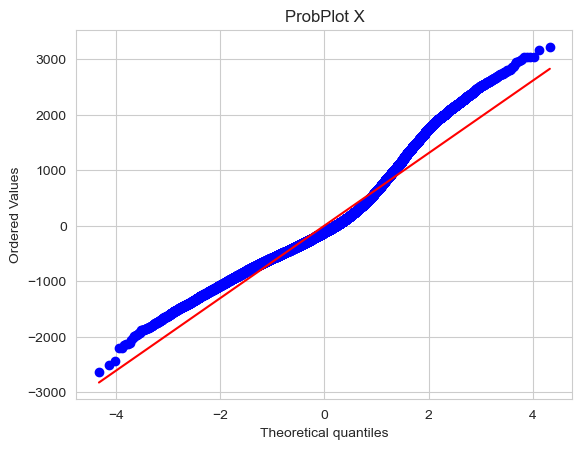

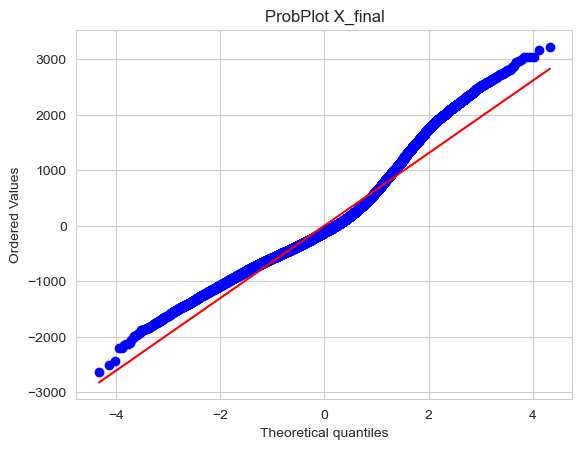

In [283]:
results = regress(Y, X)
stats.probplot(results.resid, dist='norm', plot=plt)
plt.title('ProbPlot X')
plt.show()

results = regress(Y, X_final)
stats.probplot(results.resid, dist='norm', plot=plt)
plt.title('ProbPlot X_final')

plt.show()

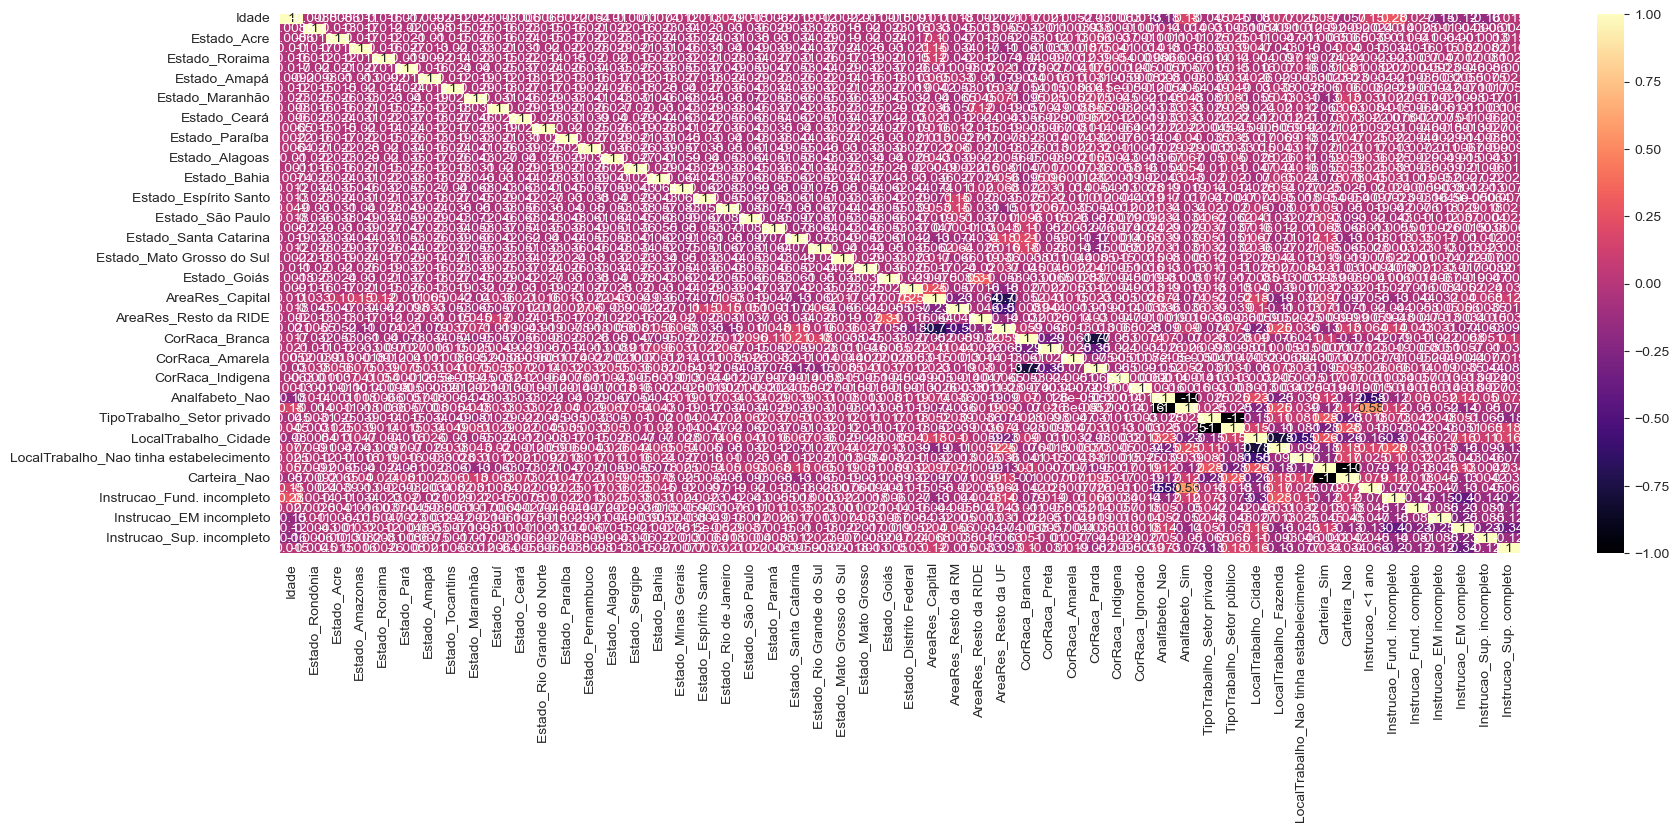

In [284]:
# Heat map
plt.figure(figsize=(20, 7))
sb.heatmap(dummies.corr(), annot = True, cmap = 'magma')
plt.show()

In [285]:
# Dividir base de teste e dados
X_var = X_final.values
Y_var = Y.values

X_train, X_test, Y_train, Y_test = train_test_split(X_var, Y_var, random_state = 0)

print('X_train samples:', X_train[0:5])
print('X_test samples:', X_test[0:5])
print('Y_train samples:', Y_train[0:5])
print('Y_test samples:', Y_test[0:5])

X_train samples: [[ 1. 27.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
   0.]
 [ 1. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.
   0.]
 [ 1. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.
   0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
   0.]
 [ 1. 23.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
   0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
   0.]
 [ 1. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

In [286]:
# MODELING

# 1. OLS

ols = LinearRegression()
ols.fit(X_train, Y_train)
ols_yhat = ols.predict(X_test)

# 2. Ridge

ridge = Ridge(alpha = 0.5)
ridge.fit(X_train, Y_train)
ridge_yhat = ridge.predict(X_test)

# 3. Lasso

lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, Y_train)
lasso_yhat = lasso.predict(X_test)

# 4. Bayesian

bayesian = BayesianRidge()
bayesian.fit(X_train, Y_train)
bayesian_yhat = bayesian.predict(X_test)

# 5. ElasticNet

en = ElasticNet(alpha = 0.01)
en.fit(X_train, Y_train)
en_yhat = en.predict(X_test)

KeyboardInterrupt: 

In [ ]:
# 1. Explained Variance Score
print('-------------------------------------------------------------------------------')
print('EXPLAINED VARIANCE SCORE:')
print('-------------------------------------------------------------------------------')
print('Explained Variance Score of OLS model is {}'.format(evs(Y_test, ols_yhat)))
print('Explained Variance Score of Ridge model is {}'.format(evs(Y_test, ridge_yhat)))
print('Explained Variance Score of Lasso model is {}'.format(evs(Y_test, lasso_yhat)))
print('Explained Variance Score of Bayesian model is {}'.format(evs(Y_test, bayesian_yhat)))
print('Explained Variance Score of ElasticNet is {}'.format(evs(Y_test, en_yhat)))
print('-------------------------------------------------------------------------------')

# 2. R-squared
print('R-SQUARED:')
print('-------------------------------------------------------------------------------')
print('R-Squared of OLS model is {}'.format(r2(Y_test, ols_yhat)))
print('R-Squared of Ridge model is {}'.format(r2(Y_test, ridge_yhat)))
print('R-Squared of Lasso model is {}'.format(r2(Y_test, lasso_yhat)))
print('R-Squared of Bayesian model is {}'.format(r2(Y_test, bayesian_yhat)))
print('R-Squared of ElasticNet is {}'.format(r2(Y_test, en_yhat)))


-------------------------------------------------------------------------------
EXPLAINED VARIANCE SCORE:
-------------------------------------------------------------------------------
Explained Variance Score of OLS model is 0.3280677007898746
Explained Variance Score of Ridge model is 0.32806820997223063
Explained Variance Score of Lasso model is 0.3280534373676608
Explained Variance Score of Bayesian model is 0.3280762503279159
Explained Variance Score of ElasticNet is 0.3273312667761846
-------------------------------------------------------------------------------
R-SQUARED:
-------------------------------------------------------------------------------
R-Squared of OLS model is 0.3280090332763359
R-Squared of Ridge model is 0.328009517813148
R-Squared of Lasso model is 0.32799490671864395
R-Squared of Bayesian model is 0.3280176575333048
R-Squared of ElasticNet is 0.32727353212906785


In [ ]:
# # mean_absolute_percentage_error do SVR
# model_SVR = svm.SVR()
# model_SVR.fit(X_train,Y_train)
# Y_pred = model_SVR.predict(X_test)

# print(mean_absolute_percentage_error(Y_test, Y_pred))

In [ ]:
# mean_absolute_percentage_error do RandomForest
model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_test)

mean_absolute_percentage_error(Y_test, Y_pred)

0.44876864682433887

In [ ]:
# mean_absolute_percentage_error do LinearRegression
model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_test)

print(mean_absolute_percentage_error(Y_test, Y_pred))

0.4450576881211055


In [ ]:
# root_mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)  # Calcula o erro quadrático médio
rmse = np.sqrt(mse)  # Calcula a raiz quadrada do erro quadrático médio
print("Mean Absolute Error:", rmse)

Mean Absolute Error: 664.20460653426


In [ ]:
cb_model = CatBoostRegressor()
cb_model.fit(X_train, Y_train)
preds = cb_model.predict(X_test) 

cb_r2_score=r2_score(Y_test, preds)
cb_r2_score

Learning rate set to 0.079929
0:	learn: 802.7287830	total: 20.7ms	remaining: 20.7s
1:	learn: 788.1835535	total: 39.1ms	remaining: 19.5s
2:	learn: 775.4752634	total: 56.8ms	remaining: 18.9s
3:	learn: 764.0770116	total: 87.2ms	remaining: 21.7s
4:	learn: 754.3786784	total: 115ms	remaining: 22.8s
5:	learn: 746.2099172	total: 138ms	remaining: 22.9s
6:	learn: 739.0554819	total: 162ms	remaining: 23s
7:	learn: 732.6509641	total: 180ms	remaining: 22.4s
8:	learn: 726.9659529	total: 201ms	remaining: 22.1s
9:	learn: 721.8699881	total: 212ms	remaining: 20.9s
10:	learn: 717.6349230	total: 221ms	remaining: 19.9s
11:	learn: 713.8578070	total: 229ms	remaining: 18.8s
12:	learn: 710.2074562	total: 236ms	remaining: 17.9s
13:	learn: 707.3274154	total: 244ms	remaining: 17.2s
14:	learn: 704.6334488	total: 251ms	remaining: 16.5s
15:	learn: 702.1283207	total: 259ms	remaining: 15.9s
16:	learn: 699.9494336	total: 268ms	remaining: 15.5s
17:	learn: 697.9572720	total: 275ms	remaining: 15s
18:	learn: 696.2429380	tot

0.3652444920844772

In [ ]:
vif_data = pd.DataFrame()
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["feature"] = X.columns
print(vif_data)


c:\Users\leovm\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\leovm\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


        VIF                                  feature
0   0.00000                                    const
1   1.21386                                    Idade
2       inf                          Estado_Rondônia
3       inf                              Estado_Acre
4       inf                          Estado_Amazonas
5       inf                           Estado_Roraima
6       inf                              Estado_Pará
7       inf                             Estado_Amapá
8       inf                         Estado_Tocantins
9       inf                          Estado_Maranhão
10      inf                             Estado_Piauí
11      inf                             Estado_Ceará
12      inf               Estado_Rio Grande do Norte
13      inf                           Estado_Paraíba
14      inf                        Estado_Pernambuco
15      inf                           Estado_Alagoas
16      inf                           Estado_Sergipe
17      inf                             Estado

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(Y_test, Y_pred)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 503.8280487724088
